### Emotion Analysis

In [250]:
# Install necessary libraries for text processing, machine learning, and deep learning
!pip install emoji  # For handling emojis in text
!pip install contractions  # For expanding contractions in text
!pip install tensorflow  # TensorFlow, includes Keras
!pip install tqdm  # For showing progress bars in loops

# Install the latest version of tf-keras (usually covered by tensorflow install)
!pip install tf-keras  # Only necessary if you want a specific version

# Optional: Specific installs for Keras if needed separately
!pip install keras  # (TensorFlow already includes Keras)

# Uncomment if you haven't downloaded necessary NLTK corpora yet
# !pip install nltk  # In case NLTK isn't installed
# import nltk
# nltk.download('stopwords')  # For stopwords
# nltk.download('punkt')  # For tokenization


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


#### Import Libraries

In [251]:
# Data manipulation and cleaning
import pandas as pd
import numpy as np
import re
import emoji
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag
from collections import Counter

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Machine Learning models and metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, accuracy_score, roc_auc_score


# Deep Learning (Keras & TensorFlow)
import torch
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Word Embeddings (Gensim, FastText, Word2Vec)
import gensim
from gensim.models import Word2Vec, FastText

# Transformers
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, Trainer, TrainingArguments

# Time
import time

# Progress bar
from tqdm import tqdm  # Progress bar for loops

#### Load and Explore Data

In [252]:
#### Load and Explore Data
def load_data(file_path):
    """Load the dataset from a file."""
    return pd.read_csv(file_path)

These explore section allows us to conduct a deep analysis to understand how much cleaning is requred and also gives insight to help desiner better systems. This explore examines missing values, duplicate entries, class distribution, text length statistics, punctuation usage, emoji occurrences, stop words frequency, and numeric-only text entries

In [253]:
def explore_data(df, text_column='text', label_column='label'):
    """Perform an extensive exploration of the dataset to check data cleanliness."""

    print("\n--- Basic Information ---")
    print(f"Dataset Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"Missing Values:\n{df.isnull().sum()}")
    print(f"Duplicate Rows: {df.duplicated().sum()}")

    print("\n--- Class Distribution ---")
    if label_column in df.columns:
        print(df[label_column].value_counts())

        # Plot class distribution
        plt.figure(figsize=(8, 4))
        df[label_column].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title("Class Distribution")
        plt.xlabel("Emotion Labels")
        plt.ylabel("Frequency")
        plt.show()
    else:
        print(f"No '{label_column}' column found!")

    print("\n--- Text Analysis ---")
    empty_texts = df[text_column].isnull().sum() + df[text_column].str.strip().eq('').sum()
    print(f"Empty or Blank Texts: {empty_texts}")

    # Checking text length distribution
    df['text_length'] = df[text_column].apply(lambda x: len(str(x).split()))
    print(f"Average Text Length: {df['text_length'].mean():.2f} words")
    print(f"Max Text Length: {df['text_length'].max()} words")
    print(f"Min Text Length: {df['text_length'].min()} words")

    # Checking for punctuation
    punctuations = df[text_column].apply(lambda x: len(re.findall(r'[^\w\s]', str(x))))
    print(f"Average Punctuation Count per Entry: {punctuations.mean():.2f}")

    # Check for emojis
    emojis_count = df[text_column].apply(lambda x: len(emoji.emoji_list(str(x))))
    print(f"Average Emoji Count per Entry: {emojis_count.mean():.2f}")

    # Checking for stop words
    stop_words = set(stopwords.words('english'))
    stop_word_counts = df[text_column].apply(lambda x: len([word for word in str(x).split() if word.lower() in stop_words]))
    print(f"Average Stop Words per Entry: {stop_word_counts.mean():.2f}")

    # Checking for numeric-only text (Fixed issue)
    numeric_texts = df[text_column].apply(lambda x: str(x).strip().isdigit()).sum()
    print(f"Entries with Only Numbers: {numeric_texts}")

    # Checking for excessive repeated characters
    repeated_char_counts = df[text_column].apply(lambda x: len(re.findall(r'(.)\1{2,}', str(x))))
    print(f"Average Excessive Repeated Characters per Entry: {repeated_char_counts.mean():.2f}")

    print("\n--- Recommendations ---")
    recommendations = []
    if empty_texts > 0:
        recommendations.append(f"Remove or handle {empty_texts} empty or blank entries.")
    if df.duplicated().sum() > 0:
        recommendations.append("Remove duplicate rows.")
    if emojis_count.sum() > 0:
        recommendations.append(f"Consider handling {emojis_count.sum()} emojis (e.g., replace with words or remove).")
    if punctuations.mean() > 0:
        recommendations.append("Remove or handle punctuation marks appropriately.")
    if numeric_texts > 0:
        recommendations.append(f"Consider removing {numeric_texts} entries containing only numbers.")
    if repeated_char_counts.mean() > 0:
        recommendations.append("Normalize excessive repeated characters (e.g., 'looooove' → 'love').")

    if recommendations:
        print("\n".join(recommendations))
    else:
        print("The dataset appears clean!")


In [254]:
#Drop empty rows from our data
def drop_empty_rows(df):
    """Drop rows with empty text values."""
    return df.dropna(subset=['text']).reset_index(drop=True)

#### Comprehensive Text Cleaning and Preprocessing (Preprocess Text)

In [255]:
        def remove_emojis(text):
            """Remove emojis from text."""
            return emoji.replace_emoji(text, replace="")

        def expand_contractions(text):
            """Expand contractions like don't -> do not"""
            return contractions.fix(text)

        def remove_duplicates(df, column='text'):
            """Remove duplicate rows based on a specific column."""
            before = df.shape[0]  # Get the initial number of rows
            df = df.drop_duplicates(subset=[column]).reset_index(drop=True)  # Remove duplicates
            after = df.shape[0]  # Get the number of rows after removal

            return df

        def remove_punctuation_and_symbols(text):
            """Remove punctuation, special characters, and standalone numbers (not in words)."""
            text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
            text = re.sub(r'@\w+', '', text)  # Remove mentions
            text = re.sub(r'#\w+', '', text)  # Remove hashtags
            text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
            text = re.sub(r'\d+', '', text)  # Remove standalone numbers
            return text

        def normalize_repeated_characters(text):
            """Normalize words with excessive character repetition while preserving natural double letters (e.g., loooove -> love).."""
            return re.sub(r'(.)\1{2,}', r'\1', text)  # Reduces sequences of 3+ to just 1


        def preprocess_text(text):
            """Clean and preprocess text."""
            text = remove_emojis(text)
            text = expand_contractions(text)
            text = remove_punctuation_and_symbols(text)
            text = normalize_repeated_characters(text)
            tokens = word_tokenize(text.lower())  # Tokenize first, then lowercase

            stop_words = set(stopwords.words('english'))
            lemmatizer = WordNetLemmatizer()

            tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
            return ' '.join(tokens)

        def preprocess_text_stemming(text):
            """Clean and preprocess text using Stemming."""
            text = remove_emojis(text)
            text = expand_contractions(text)
            text = remove_punctuation_and_symbols(text)
            text = normalize_repeated_characters(text)
            tokens = word_tokenize(text.lower())  # Tokenize first, then lowercase

            stop_words = set(stopwords.words('english'))
            stemmer = PorterStemmer()

            tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
            return ' '.join(tokens)

        def apply_preprocessing(df):
            """Apply preprocessing to the text column."""
            df['text'] = df['text'].apply(preprocess_text)
            return df

        def apply_preprocessing_stemming(df):
            """Apply stemming-based preprocessing to the text column."""
            df['text_stemmed'] = df['text'].apply(preprocess_text_stemming)
            return df

### Measuring Performance and Effectiveness

In [256]:
# Function to measure execution time
def measure_time(func, df):
    start_time = time.time()
    df = func(df)
    end_time = time.time()
    execution_time = end_time - start_time
    return df, execution_time

#### Feature Engineering

In [257]:
def create_features_Tfidf(corpus):
    """Convert text into numerical representations."""
    vectorizer = TfidfVectorizer(max_features=5000)
    features = vectorizer.fit_transform(corpus)
    return features, vectorizer

def create_features_CountVectorizer(corpus):
    """Convert text into numerical representations."""
    vectorizer = CountVectorizer(max_features=5000)
    features = vectorizer.fit_transform(corpus)
    return features, vectorizer

# Create features using Word2Vec
def create_features_Word2Vec(corpus):
    """Convert text into numerical representations using Word2Vec."""
    tokenized_corpus = [doc.split() for doc in corpus]

    # Train Word2Vec model
    model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)

    # Calculate feature vectors as the mean of word vectors for each document
    features = np.array([
        np.mean([
            model.wv[word] for word in doc if word in model.wv
        ] or [np.zeros(100)], axis=0) for doc in tokenized_corpus
    ])
    return features, model


In [258]:
# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Load pre-trained BERT model (for embeddings)
model = BertModel.from_pretrained("bert-base-uncased")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set model to evaluation mode (no gradients needed)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [259]:


from tqdm import tqdm
import numpy as np

def batch_bert_embeddings(corpus, batch_size=256):
    """Efficiently process BERT embeddings in batches with progress tracking."""
    features = []
    num_batches = len(corpus) // batch_size + 1  # Calculate total batches

    print(f"Processing {len(corpus)} texts in {num_batches} batches...")

    for i in tqdm(range(0, len(corpus), batch_size), desc="Extracting BERT Features"):
        batch = corpus[i:i + batch_size].tolist()  # Convert batch to list
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)  # Move to GPU

        with torch.no_grad():
            outputs = model(**inputs)

        batch_features = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token representation
        features.append(batch_features)

    print("BERT Feature Extraction Completed!")
    return np.vstack(features)  # Combine all batches


### Exploratory data analysis(EDA)

#### Model Training

##### Logistic Regression

In [260]:
def train_logistic_regression(X, y):
    """Train and evaluate a Logistic Regression model."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    print("\n--- Logistic Regression Evaluation ---")
    evaluate_model(model, X_test, y_test, "Logistic Regression")
    return model

##### Random Forest

In [261]:
def train_random_forest(X, y):
    """Train and evaluate a Random Forest Classifier."""
    X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    print("\n--- Random Forest Evaluation ---")
    evaluate_model(model, X_test, y_test, "Random Forest")
    return model

##### Support Vector Machine

In [262]:
def train_svm(X, y):
    """Train and evaluate a Support Vector Machine (SVM)."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # model = SVC(probability=False)

    """Train and evaluate a fast Support Vector Machine (SVM) using LinearSVC."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearSVC(dual=False)  # 🚀 Much faster than SVC(kernel='linear')
    model.fit(X_train, y_train)

    # model.fit(X_train, y_train)
    print("\n--- SVM Evaluation ---")
    evaluate_model(model, X_test, y_test, "Support Vector Machine (SVM)")
    return model


#### Evaluate Model

In [263]:
#Evaluation Function


# Dictionary to store model performance
performance_metrics = {}

def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate a trained model and visualize the results."""
    try:
        # Predict on the test set
        y_pred = model.predict(X_test)

        # Convert Deep Learning Model Outputs to Class Labels**
        if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
            y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

        # Check if the model supports probability predictions
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)  # Get probability scores
        else:
            y_prob = None  # Models like LinearSVC do not support probability predictions

    except Exception as e:
        print(f"Error in prediction: {e}")
        return

    # **Print Classification Report**
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # **Store Model Performance Metrics**
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    performance_metrics[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }

    print(f"\nPrecision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # **Plot Confusion Matrix**
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()

    # **Plot ROC Curve (Only for Binary Classification)**
    if y_prob is not None and len(np.unique(y_test)) == 2:
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])  # Take probability of class 1
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()


 #### Predict

In [264]:
def predict_emotion(model, text, vectorizer):
    """Predict the emotion of a single input text."""
    processed_text = preprocess_text(text)
    features = vectorizer.transform([processed_text])
    return model.predict(features)


Exploring and Preprocessing Emotion Dataset for NLP Analysis


--- Basic Information ---
Dataset Shape: (416809, 2)
Columns: ['text', 'label']
Missing Values:
text     0
label    0
dtype: int64
Duplicate Rows: 686

--- Class Distribution ---
label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64


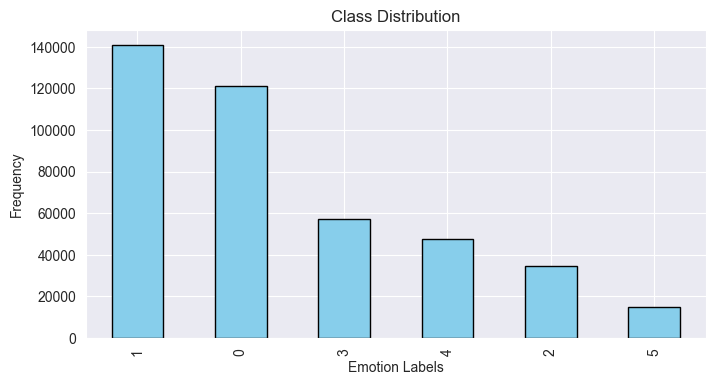


--- Text Analysis ---
Empty or Blank Texts: 0
Average Text Length: 19.21 words
Max Text Length: 178 words
Min Text Length: 1 words
Average Punctuation Count per Entry: 0.00
Average Emoji Count per Entry: 0.00
Average Stop Words per Entry: 9.85
Entries with Only Numbers: 0
Average Excessive Repeated Characters per Entry: 0.01

--- Recommendations ---
Remove duplicate rows.
Normalize excessive repeated characters (e.g., 'looooove' → 'love').


In [265]:
emotions_df = load_data('data/emotions.csv')
explore_data(emotions_df, text_column='text')


#### Class Distribution (Imbalance Visualization)

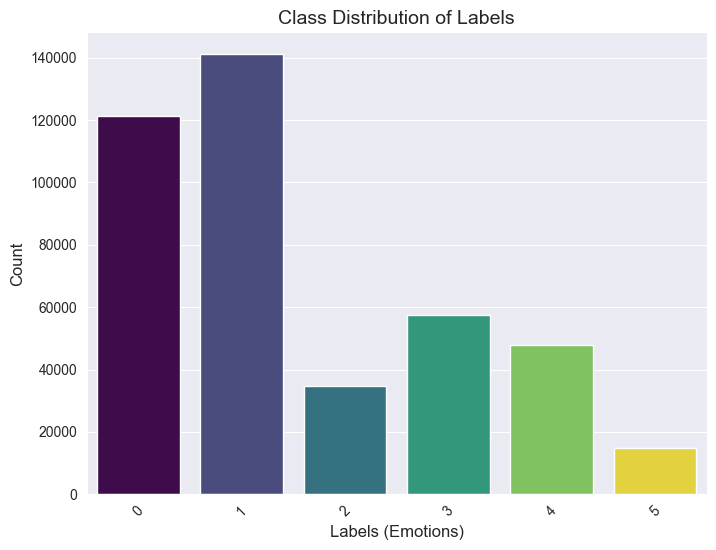

In [266]:
# Plot class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=emotions_df, hue='label', dodge=False, palette='viridis', legend=False)
plt.title("Class Distribution of Labels", fontsize=14)
plt.xlabel("Labels (Emotions)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()

#### Remove duplicated data

In [267]:
emotions_df = remove_duplicates(emotions_df, column='text')  # Remove duplicates first
emotions_df = emotions_df[emotions_df['text'].str.strip() != ""].reset_index(drop=True)


### Undersampling data

In [268]:
# Display the first few rows
emotions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393822 entries, 0 to 393821
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         393822 non-null  object
 1   label        393822 non-null  int64 
 2   text_length  393822 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.0+ MB


In [269]:
# Undersampling 14k rows from each category 0, 1, 2, 3, 4, 5
# Find the least frequent class count
"""min_count = emotions_df['label'].value_counts().min()  # Get smallest class size
print(f"Undersampling to {min_count} rows per class")"""

min_count = 834
print(f"Undersampling to {min_count} rows per class")

# Apply undersampling to match the smallest class
undersample_dataset = pd.concat([
    emotions_df[emotions_df['label'] == label].sample(n=min_count, random_state=42)
    for label in emotions_df['label'].unique()
])


# Display new class distribution
print("\nNew Class Distribution After Undersampling:")
print(undersample_dataset['label'].value_counts())


Undersampling to 834 rows per class

New Class Distribution After Undersampling:
label
4    834
0    834
2    834
1    834
5    834
3    834
Name: count, dtype: int64


#### Exploring undersampled data


--- Basic Information ---
Dataset Shape: (5004, 3)
Columns: ['text', 'label', 'text_length']
Missing Values:
text           0
label          0
text_length    0
dtype: int64
Duplicate Rows: 0

--- Class Distribution ---
label
4    834
0    834
2    834
1    834
5    834
3    834
Name: count, dtype: int64


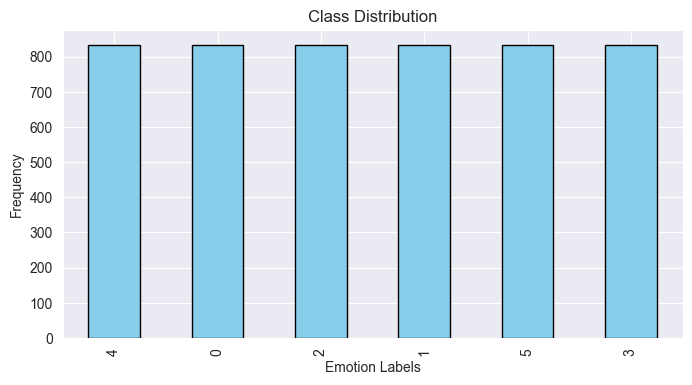


--- Text Analysis ---
Empty or Blank Texts: 0
Average Text Length: 19.57 words
Max Text Length: 66 words
Min Text Length: 2 words
Average Punctuation Count per Entry: 0.00
Average Emoji Count per Entry: 0.00
Average Stop Words per Entry: 10.10
Entries with Only Numbers: 0
Average Excessive Repeated Characters per Entry: 0.01

--- Recommendations ---
Normalize excessive repeated characters (e.g., 'looooove' → 'love').


In [270]:
explore_data(undersample_dataset, text_column='text')  # A djust 'text' if your column name differs

### Measuring Lemmatization/Stemming Processing Time

In [271]:
# Measure Lemmatization Time
df, lemmatization_time = measure_time(apply_preprocessing, undersample_dataset)
print(f"Lemmatization Time: {lemmatization_time:.4f} seconds")

# Measure Stemming Time
df, stemming_time = measure_time(apply_preprocessing_stemming, undersample_dataset)
print(f"Stemming Time: {stemming_time:.4f} seconds")

Lemmatization Time: 2.8943 seconds
Stemming Time: 3.1566 seconds


## Exploratory Data Analysis (EDA)

#### Class Distribution of Emotion Labels After Undersampling

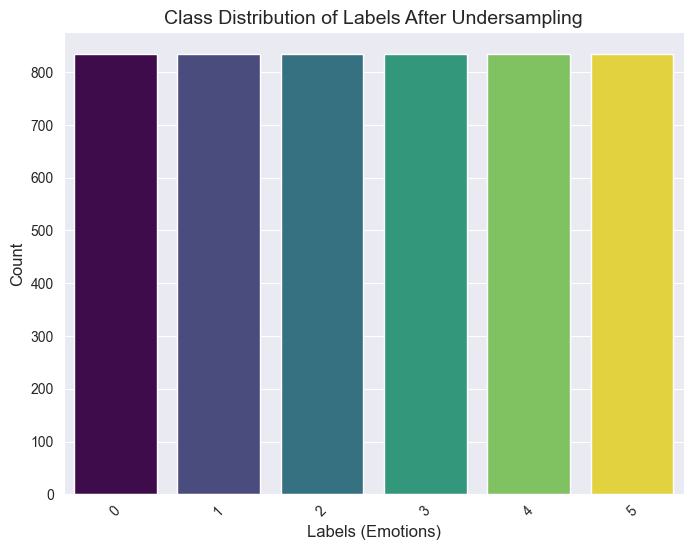

In [272]:
# Plot class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=undersample_dataset, hue='label', dodge=False, palette='viridis', legend=False)
plt.title("Class Distribution of Labels After Undersampling", fontsize=14)
plt.xlabel("Labels (Emotions)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()

#### Most Frequent Words in Text Data (Excluding Stopwords)

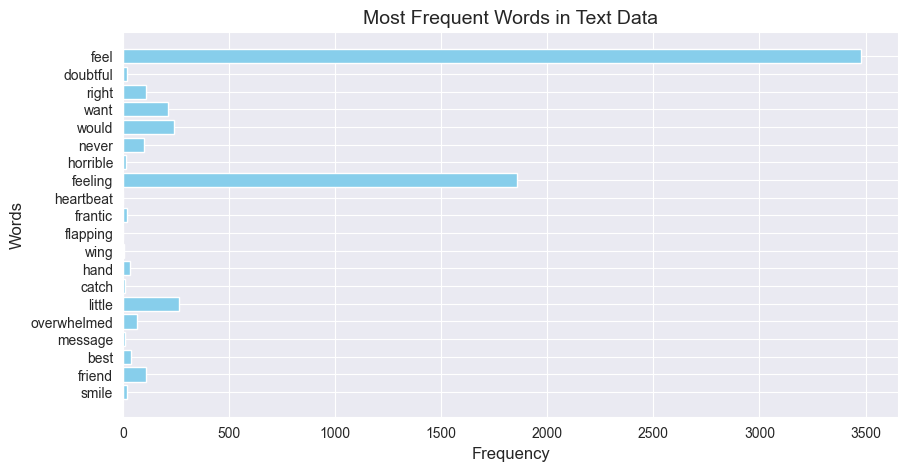

In [273]:

stop_words = set(stopwords.words('english'))

# Count word occurrences
word_counts = Counter(" ".join(undersample_dataset['text']).split())
filtered_words = {word: count for word, count in word_counts.items() if word.lower() not in stop_words}

# Plot top 20 words
plt.figure(figsize=(10,5))
plt.barh(list(filtered_words.keys())[:20], list(filtered_words.values())[:20], color='skyblue')
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Words", fontsize=12)
plt.title("Most Frequent Words in Text Data", fontsize=14)
plt.gca().invert_yaxis()
plt.show()


#### Overall Text Length Distribution

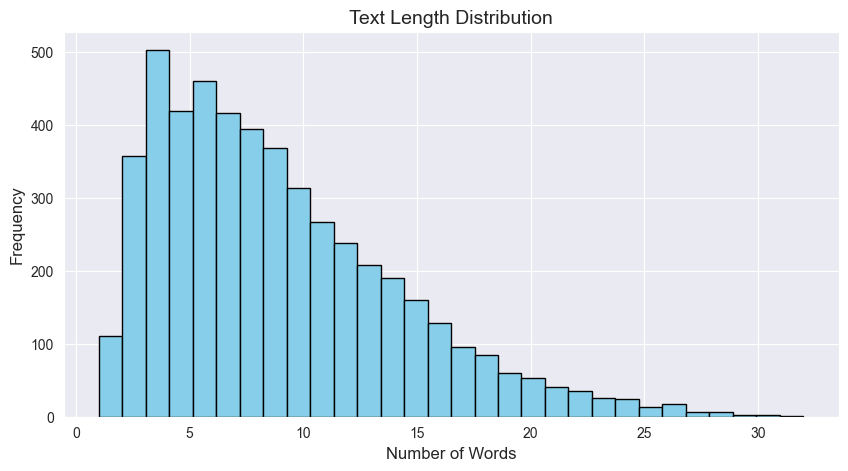

In [274]:
undersample_dataset['text_length'] = undersample_dataset['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10,5))
plt.hist(undersample_dataset['text_length'], bins=30, color='skyblue', edgecolor='black')
plt.title("Text Length Distribution", fontsize=14)
plt.xlabel("Number of Words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

#### Word Count Distribution by Emotion

In [275]:
# !pip install plotly
import plotly.express as px

# Create a column for text length (word count)
undersample_dataset['word_count'] = undersample_dataset['text'].apply(lambda x: len(str(x).split()))

# Box plot for word count distribution across emotion labels
fig = px.box(undersample_dataset, y="word_count", color="label", template="plotly_white")

# Show the plot
fig.show()


#### Class Distribution of Emotion Labels

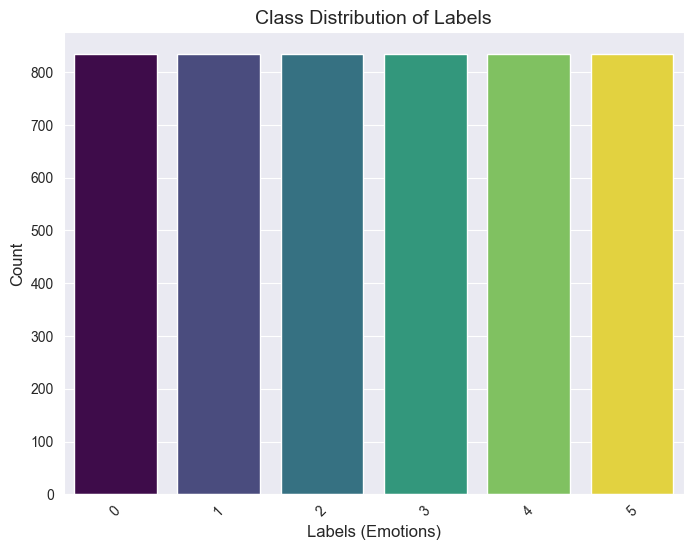

In [276]:
# Plot class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=undersample_dataset, hue='label', dodge=False, palette='viridis', legend=False)
plt.title("Class Distribution of Labels", fontsize=14)
plt.xlabel("Labels (Emotions)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()

#### Emotion-Specific Keywords

In [277]:
# TF-IDF analysis
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(undersample_dataset['text'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df['emotion'] = undersample_dataset['label']

# Find top keywords for each emotion
top_keywords = {}
for emotion in tfidf_df['emotion'].unique():
    emotion_data = tfidf_df[tfidf_df['emotion'] == emotion]
    top_keywords[emotion] = emotion_data.mean(axis=0).sort_values(ascending=False).head(10)

print(top_keywords)


{nan: ability      NaN
able         NaN
absolutely   NaN
accepted     NaN
aching       NaN
across       NaN
act          NaN
action       NaN
actually     NaN
add          NaN
dtype: float64, 2.0: emotion    2.000000
rude       0.121919
often      0.110263
catch      0.089038
tend       0.086598
feel       0.085372
pas        0.082163
missed     0.082040
want       0.081354
follow     0.079175
dtype: float64, 0.0: feel          0.118306
deeply        0.097935
funny         0.084251
peaceful      0.071463
needy         0.060677
little        0.055921
google        0.053422
still         0.052374
test          0.051761
passionate    0.051693
dtype: float64, 5.0: emotion      5.000000
feel         0.088585
stupid       0.065055
like         0.048748
mean         0.047403
done         0.046761
lousy        0.046715
anyone       0.046625
something    0.042639
mom          0.042596
dtype: float64, 1.0: emotion    1.000000
feel       0.074149
thought    0.067999
fond       0.067360
people    

#### Heatmap for TF-IDF Top Keywords

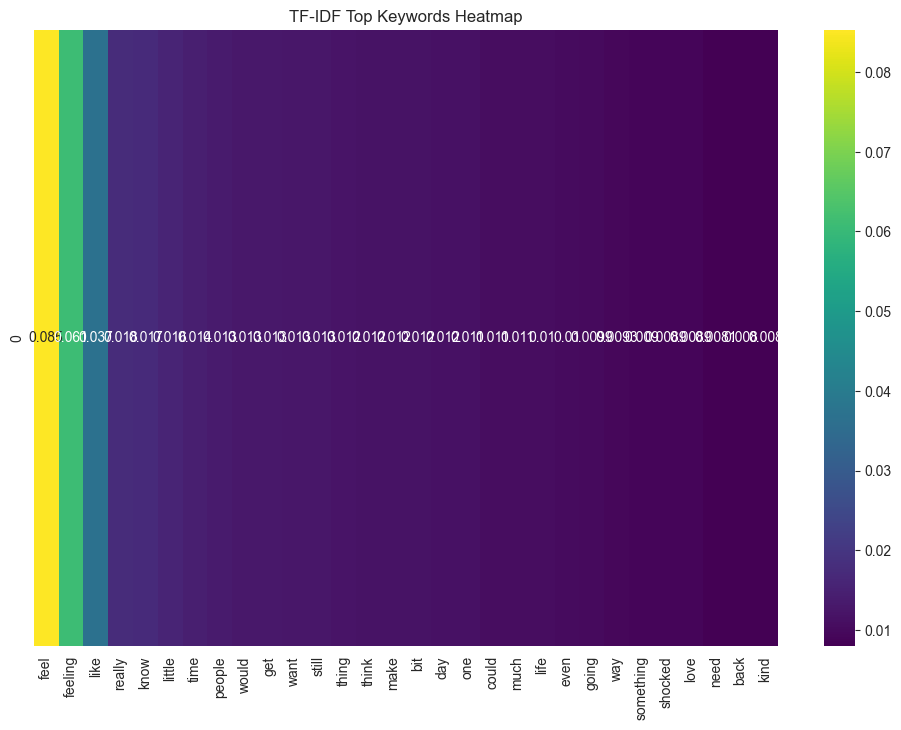

In [278]:
# Heatmap for TF-IDF scores
tfidf_top_words = tfidf_df.drop('emotion', axis=1).mean(axis=0).sort_values(ascending=False).head(30)
plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(tfidf_top_words).T, annot=True, cmap='viridis')
plt.title("TF-IDF Top Keywords Heatmap")
plt.show()


In [279]:
emotions_df = apply_preprocessing(undersample_dataset)

#### Word Cloud: Visualizing the most common words

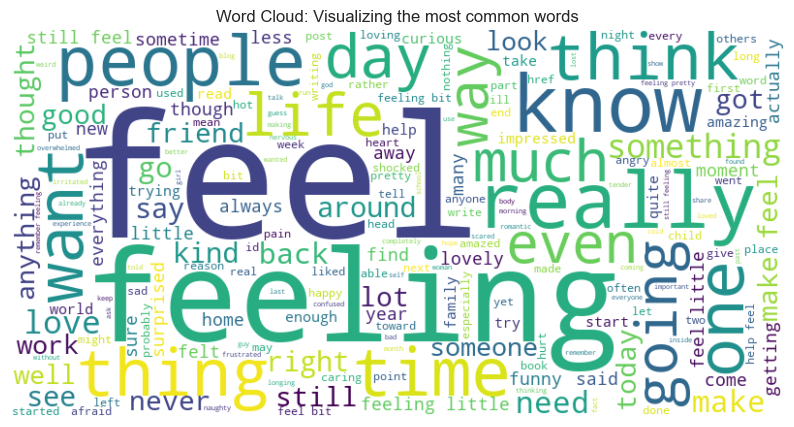

In [280]:
emotions_string = ' '.join(emotions_df['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(emotions_string)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud: Visualizing the most common words")

plt.show()

---

### Feature Extraction using Text Vectorization Techniques

In [281]:
#create_features_Tfidf
XTfidf, vectorizer = create_features_Tfidf(emotions_df['text'])
XCountVectorizer, vectorizer = create_features_CountVectorizer(emotions_df['text'])
XWord2Vec, word2vec_model = create_features_Word2Vec(emotions_df['text'])


y = emotions_df['label']  # Assuming the label column is named 'label'


In [282]:
# Run BERT embedding extraction

# XBERT = batch_bert_embeddings(emotions_df['text'], batch_size=256)  # Lower batch_size if memory issues occur




In [283]:
# Extract and display the shape of each feature representation
print(f"TF-IDF Shape: {XTfidf.shape}")
print(f"Word2Vec Shape: {XWord2Vec.shape}")
print(f"CountVectorizer Shape: {XCountVectorizer.shape}")
# print(f"BERT Embeddings Shape: {XBERT.shape}")


TF-IDF Shape: (5004, 5000)
Word2Vec Shape: (5004, 100)
CountVectorizer Shape: (5004, 5000)


### Logistic Regression Model - TFIDF


--- Logistic Regression Evaluation ---

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       173
           1       0.81      0.84      0.83       155
           2       0.91      0.94      0.92       155
           3       0.88      0.86      0.87       165
           4       0.92      0.87      0.89       189
           5       0.93      0.96      0.95       164

    accuracy                           0.89      1001
   macro avg       0.89      0.89      0.89      1001
weighted avg       0.89      0.89      0.89      1001


Precision: 0.8865
Recall: 0.8861
F1-score: 0.8861

Confusion Matrix:
[[149   8   3   7   5   1]
 [ 12 130   6   2   2   3]
 [  0   3 145   5   0   2]
 [  6   8   2 142   6   1]
 [  4   9   2   6 164   4]
 [  2   2   1   0   2 157]]


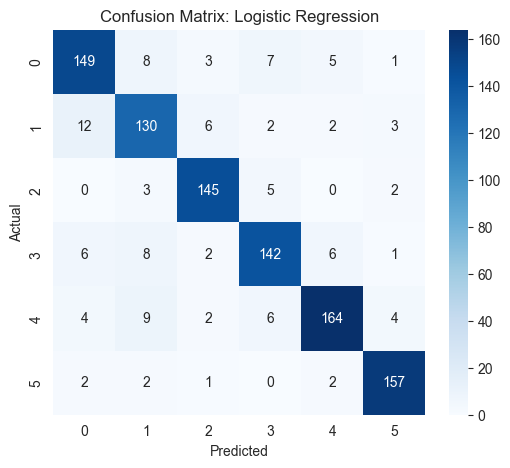

In [284]:
logistic_model = train_logistic_regression(XTfidf, y)

### Logistic Regression Model - CountVectorizer


--- Logistic Regression Evaluation ---

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       173
           1       0.84      0.85      0.85       155
           2       0.92      0.94      0.93       155
           3       0.88      0.88      0.88       165
           4       0.92      0.87      0.90       189
           5       0.92      0.97      0.94       164

    accuracy                           0.90      1001
   macro avg       0.90      0.90      0.90      1001
weighted avg       0.90      0.90      0.90      1001


Precision: 0.8962
Recall: 0.8961
F1-score: 0.8958

Confusion Matrix:
[[149  10   2   7   3   2]
 [ 10 132   5   2   1   5]
 [  0   2 146   5   0   2]
 [  4   5   2 146   7   1]
 [  5   7   2   6 165   4]
 [  0   1   1   0   3 159]]


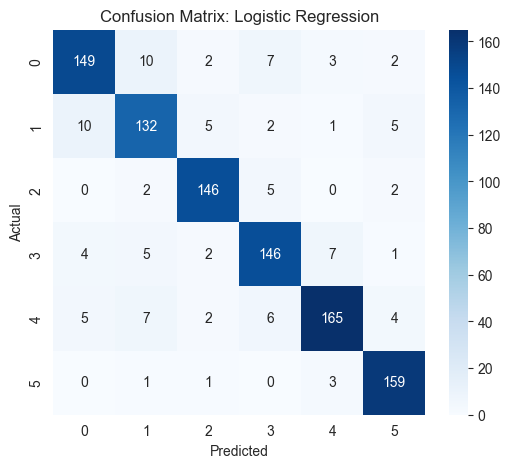

In [285]:
logistic_model_XCountVectorizer = train_logistic_regression(XCountVectorizer, y)


### Random Forest Model - TFIDF


--- Random Forest Evaluation ---

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.74      0.80       173
           1       0.70      0.82      0.76       155
           2       0.95      0.95      0.95       155
           3       0.92      0.85      0.88       165
           4       0.91      0.89      0.90       189
           5       0.90      0.98      0.94       164

    accuracy                           0.87      1001
   macro avg       0.87      0.87      0.87      1001
weighted avg       0.88      0.87      0.87      1001


Precision: 0.8755
Recall: 0.8711
F1-score: 0.8714

Confusion Matrix:
[[128  36   1   5   1   2]
 [ 14 127   4   1   4   5]
 [  0   2 148   3   0   2]
 [  5  10   0 140   9   1]
 [  2   5   2   4 169   7]
 [  0   1   0   0   3 160]]


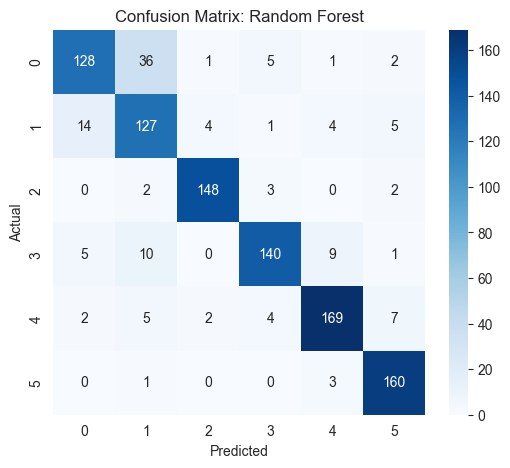

In [286]:
random_forest_model = train_random_forest(XTfidf, y)

### Random Forest Model - CountVectorizer


--- Random Forest Evaluation ---

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       173
           1       0.80      0.84      0.82       155
           2       0.94      0.96      0.95       155
           3       0.93      0.87      0.90       165
           4       0.88      0.92      0.90       189
           5       0.90      0.96      0.93       164

    accuracy                           0.89      1001
   macro avg       0.89      0.89      0.89      1001
weighted avg       0.90      0.89      0.89      1001


Precision: 0.8952
Recall: 0.8941
F1-score: 0.8938

Confusion Matrix:
[[141  21   1   5   2   3]
 [ 10 130   5   1   4   5]
 [  0   1 149   3   0   2]
 [  2   6   1 144  11   1]
 [  2   4   1   2 174   6]
 [  0   0   1   0   6 157]]


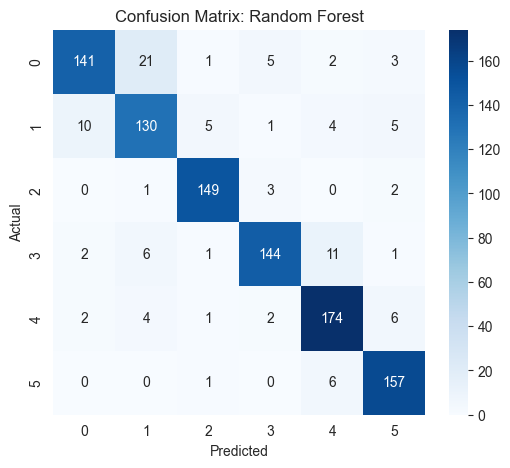

In [287]:
random_forest_model_XCountVectorizer = train_random_forest(XCountVectorizer, y)

### Support Vector Machine (SVM) Model - TFIDF


--- SVM Evaluation ---

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       173
           1       0.88      0.85      0.86       155
           2       0.91      0.96      0.94       155
           3       0.90      0.87      0.89       165
           4       0.92      0.90      0.91       189
           5       0.92      0.95      0.94       164

    accuracy                           0.91      1001
   macro avg       0.91      0.91      0.91      1001
weighted avg       0.91      0.91      0.91      1001


Precision: 0.9068
Recall: 0.9071
F1-score: 0.9067

Confusion Matrix:
[[157   6   3   4   3   0]
 [  9 131   6   3   1   5]
 [  0   1 149   3   0   2]
 [  3   7   2 144   7   2]
 [  4   2   2   6 171   4]
 [  2   2   1   0   3 156]]


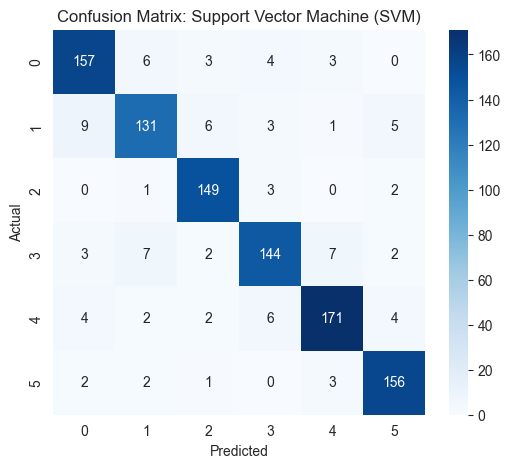

In [288]:
svm_model = train_svm(XTfidf, y)

### Support Vector Machine (SVM) Model - CountVectorizer


--- SVM Evaluation ---

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       173
           1       0.88      0.86      0.87       155
           2       0.94      0.95      0.95       155
           3       0.93      0.88      0.91       165
           4       0.91      0.91      0.91       189
           5       0.93      0.93      0.93       164

    accuracy                           0.91      1001
   macro avg       0.91      0.91      0.91      1001
weighted avg       0.91      0.91      0.91      1001


Precision: 0.9083
Recall: 0.9081
F1-score: 0.9080

Confusion Matrix:
[[156   7   2   5   2   1]
 [  8 134   4   1   3   5]
 [  3   2 148   1   0   1]
 [  5   5   1 146   7   1]
 [  5   2   2   4 172   4]
 [  2   3   1   0   5 153]]


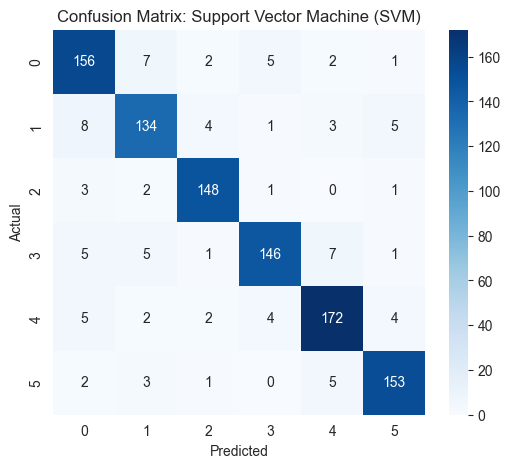

In [289]:
svm_model_CountVectoerizer = train_svm(XCountVectorizer, y)

### Reshape Data for Deep Learning
Splitting the dataset into training and testing sets ensures the model is trained properly and evaluated fairly on unseen data, helping assess its ability to generalize

In [290]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(XTfidf, y, test_size=0.2, random_state=42)


#### Preprocessing TF-IDF Features for Deep Learning Models (RNN & LSTM)

In [291]:
# Convert Sparse TF-IDF Matrix to Dense Format
XTfidf_dense = XTfidf.toarray()  # Convert entire dataset to dense format

# First, Split the Dataset (BEFORE Reshaping)
X_train, X_test, y_train, y_test = train_test_split(XTfidf_dense, y, test_size=0.2, random_state=42)

# Now, Reshape for RNN & LSTM(Add a Time Step Dimension)
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Print Shape for Verification
print(f"Original XTfidf shape: {XTfidf.shape}")
print(f"Reshaped X_train shape: {X_train_reshaped.shape}")
print(f"Reshaped X_test shape: {X_test_reshaped.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


Original XTfidf shape: (5004, 5000)
Reshaped X_train shape: (4003, 1, 5000)
Reshaped X_test shape: (1001, 1, 5000)
y_train shape: (4003,)
y_test shape: (1001,)


### Simple Recurrent Neural Network model (SimpleRNN)

In [292]:
# Define the SimpleRNN model
n_classes = len(np.unique(y))

rnn_model = Sequential()
rnn_model.add(Input(shape=(1, XTfidf_dense.shape[1])))  # Adjusted input shape for TF-IDF

rnn_model.add(SimpleRNN(256, activation='tanh', return_sequences=True))  # First RNN layer
rnn_model.add(Dropout(0.2))  # Reduce overfitting

rnn_model.add(SimpleRNN(128, activation='tanh', return_sequences=True))  # Second RNN layer
rnn_model.add(Dropout(0.2))

rnn_model.add(SimpleRNN(64, activation='tanh'))  # Final RNN layer
rnn_model.add(Dropout(0.2))

rnn_model.add(Dense(50, activation='relu'))  # Dense hidden layer
rnn_model.add(Dense(n_classes, activation='softmax'))  # Output layer for multi-class classification

# Compile the model with Adam optimizer and a learning rate
rnn_model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

rnn_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_12 (SimpleRNN)       │ (None, 1, 256)         │     1,345,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_13 (SimpleRNN)       │ (None, 1, 128)         │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_14 (SimpleRNN)       │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 50)             │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,410,980 (5.38 MB)

 Trainable params: 1,410,980 (5.38 MB)

 Non-trainable params: 0 (0.00 B)

In [293]:
# Train the model
rnn_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.2842 - loss: 1.7520
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8802 - loss: 0.6644
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9790 - loss: 0.0874
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9952 - loss: 0.0293
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9944 - loss: 0.0206
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9977 - loss: 0.0103
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9987 - loss: 0.0067
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9977 - loss: 0.0086
Epoch 9/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9980 - loss: 0.0068
Epoch 10/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9994 - loss: 0.0033


#### Evaluation

In [294]:
# Evaluate the model
loss, accuracy = rnn_model.evaluate(X_test_reshaped, y_test, verbose=1)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8302 - loss: 0.5909
Test Loss: 0.605628490447998
Test Accuracy: 0.8301698565483093


#### Training the RNN Model with Early Stopping & Performance Visualization

Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9985 - loss: 0.0046 - val_accuracy: 0.8322 - val_loss: 0.6412
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9983 - loss: 0.0041 - val_accuracy: 0.8342 - val_loss: 0.6363
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9996 - loss: 0.0023 - val_accuracy: 0.8212 - val_loss: 0.6764
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9998 - loss: 0.0025 - val_accuracy: 0.8142 - val_loss: 0.7193
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9977 - loss: 0.0063 - val_accuracy: 0.8292 - val_loss: 0.6939
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9987 - loss: 0.0078 - val_accuracy: 0.8242 - val_loss: 0.7072
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9984 - loss: 0.0047 - val_accuracy: 0.8102 - val_loss: 0.7639


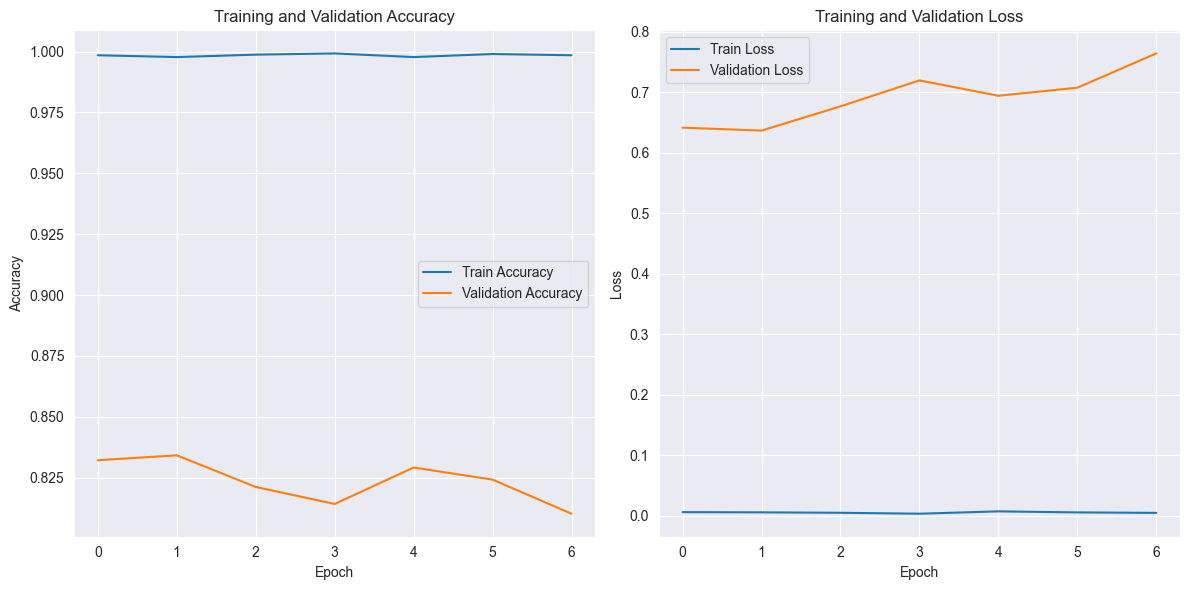

In [295]:

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = rnn_model.fit(X_train_reshaped, y_train,
                         epochs=10, batch_size=32,
                         validation_data=(X_test_reshaped, y_test),
                         callbacks=[early_stopping], verbose=1)


# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 6))


# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#### Generating Predictions and Evaluating Model Performance with ROC AUC

In [296]:
# Generate Predictions Using rnn_model
y_pred = rnn_model.predict(X_test_reshaped)  # Get probability predictions

#  Convert y_test to One-Hot Encoding
y_test_one_hot = np.zeros((y_test.shape[0], np.max(y_test) + 1))  # Ensure correct shape
y_test_one_hot[np.arange(y_test.shape[0]), y_test] = 1  # Convert to one-hot format


roc_auc = roc_auc_score(y_test_one_hot, y_pred, multi_class='ovr')
print(f"Multi-Class ROC AUC Score: {roc_auc:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Multi-Class ROC AUC Score: 0.9754


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       173
           1       0.80      0.74      0.77       155
           2       0.84      0.90      0.87       155
           3       0.83      0.81      0.82       165
           4       0.83      0.86      0.85       189
           5       0.88      0.86      0.87       164

    accuracy                           0.83      1001
   macro avg       0.83      0.83      0.83      1001
weighted avg       0.83      0.83      0.83      1001


Precision: 0.8340
Recall: 0.8342
F1-score: 0.8336

Confusion Matrix:
[[143   6   6   9   7   2]
 [ 10 115  10   5   6   9]
 [  4   6 140   3   0   2]
 [  7   8   6 133   8   3]
 [  7   5   2   9 163   3]
 [  5   3   2   1  12 141]]


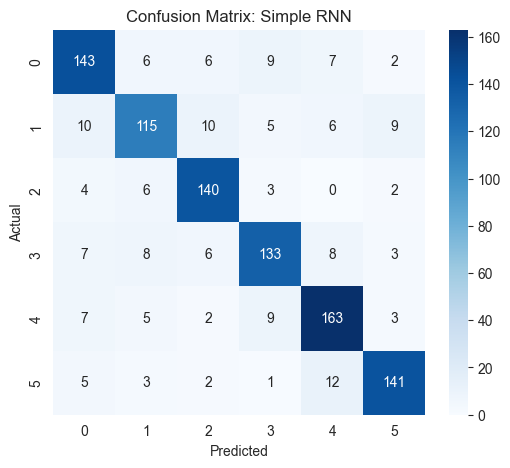

In [297]:
evaluate_model(rnn_model, X_test_reshaped, y_test, "Simple RNN")

### Predicting Emotion from Sample Text Using Trained RNN Model

In [298]:
sample_text = ["I feel very happy today!"]  # Example input

# Convert text to TF-IDF features
sample_tfidf = vectorizer.transform(sample_text).toarray()
sample_reshaped = sample_tfidf.reshape(sample_tfidf.shape[0], 1, sample_tfidf.shape[1])

# Predict Emotion
predicted_label = rnn_model.predict(sample_reshaped)
print(f"Predicted Emotion: {np.argmax(predicted_label)}")  # Get predicted class


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
Predicted Emotion: 1


### Long Short-Term Memory (LSTM)

In [299]:
# Define the LSTM model
n_classes = len(np.unique(y))

lstm_model = Sequential()

lstm_model.add(Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))

lstm_model.add(LSTM(128, activation='tanh', return_sequences=True))

lstm_model.add(LSTM(64, activation='tanh', return_sequences=True))  # First LSTM
lstm_model.add(Dropout(0.2))  # Reduced dropout for better learning

lstm_model.add(LSTM(32, activation='tanh'))  # Second LSTM
lstm_model.add(Dropout(0.2))  # Reduced dropout

lstm_model.add(Dense(n_classes, activation='softmax'))


lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 1, 128)         │     2,626,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,688,070 (10.25 MB)

 Trainable params: 2,688,070 (10.25 MB)

 Non-trainable params: 0 (0.00 B)

In [300]:
# Train the model
lstm_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.1887 - loss: 1.7898
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.5983 - loss: 1.3521
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.8627 - loss: 0.4158
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9586 - loss: 0.1578
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9865 - loss: 0.0726
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9949 - loss: 0.0347
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.9958 - loss: 0.0225
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9970 - loss: 0.0171
Epoch 9/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9976 - loss: 0.0145
Epoch 10/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9967 - loss: 0.0154


In [301]:
# Evaluate the model
loss, accuracy = lstm_model.evaluate(X_test_reshaped, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7891 - loss: 0.8714
Test Loss: 0.8672223687171936
Test Accuracy: 0.791208803653717


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       173
           1       0.71      0.77      0.74       155
           2       0.74      0.85      0.79       155
           3       0.75      0.79      0.77       165
           4       0.89      0.80      0.84       189
           5       0.93      0.84      0.88       164

    accuracy                           0.79      1001
   macro avg       0.79      0.79      0.79      1001
weighted avg       0.80      0.79      0.79      1001


Precision: 0.7973
Recall: 0.7912
F1-score: 0.7924

Confusion Matrix:
[[121  24  14  10   3   1]
 [ 14 119  10   4   2   6]
 [  4   5 132  11   0   3]
 [  6   6  14 130   9   0]
 [ 13   4   1  18 152   1]
 [  2  10   8   1   5 138]]


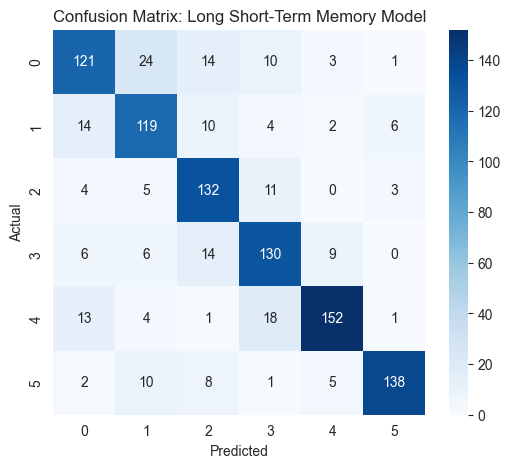

In [302]:
evaluate_model(lstm_model, X_test_reshaped, y_test, "Long Short-Term Memory Model")

#### Evaluating LSTM Model Performance Using ROC AUC Score

In [303]:
# Generate Predictions Using lstm_model
y_pred = lstm_model.predict(X_test_reshaped)  # Get probability predictions

#  Convert y_test to One-Hot Encoding
y_test_one_hot = np.zeros((y_test.shape[0], np.max(y_test) + 1))  # Ensure correct shape
y_test_one_hot[np.arange(y_test.shape[0]), y_test] = 1  # Convert to one-hot format

roc_auc = roc_auc_score(y_test_one_hot, y_pred, multi_class='ovr')
print(f"Multi-Class ROC AUC Score: {roc_auc:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Multi-Class ROC AUC Score: 0.9602


#### Training the RNN Model with Early Stopping & Performance Visualization

Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9986 - loss: 0.0092 - val_accuracy: 0.7882 - val_loss: 0.8711
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9984 - loss: 0.0084 - val_accuracy: 0.7902 - val_loss: 0.9223
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9984 - loss: 0.0085 - val_accuracy: 0.7852 - val_loss: 0.9466
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9976 - loss: 0.0071 - val_accuracy: 0.7942 - val_loss: 0.9591
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9983 - loss: 0.0066 - val_accuracy: 0.7942 - val_loss: 0.9653
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.9978 - loss: 0.0086 - val_accuracy: 0.7892 - val_loss: 1.0003


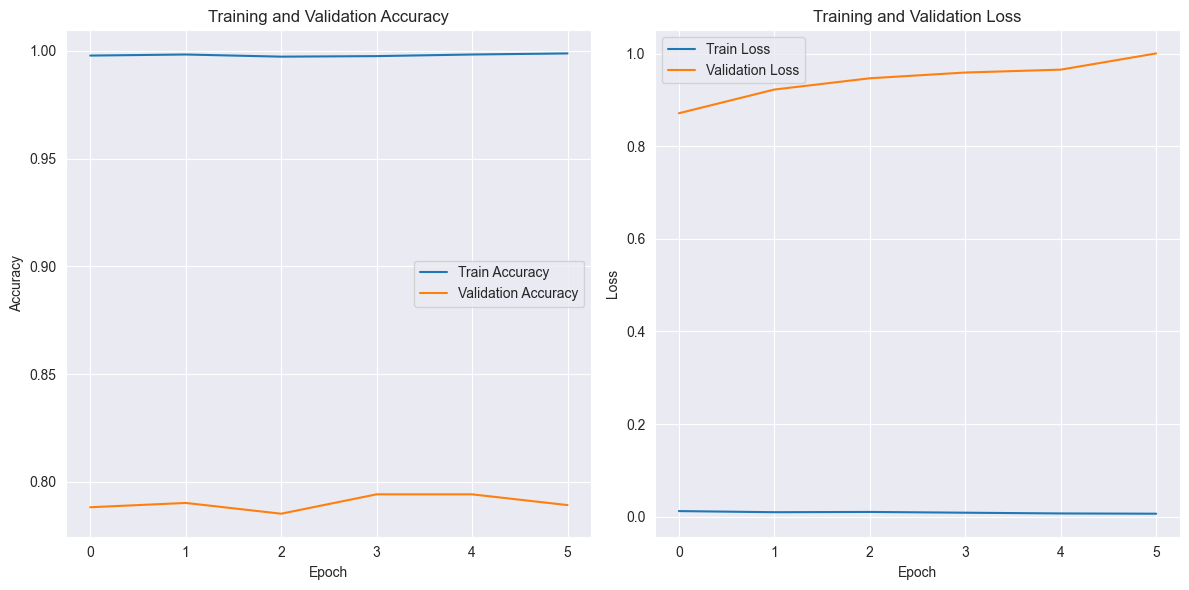

In [304]:

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = lstm_model.fit(X_train_reshaped, y_train,
                         epochs=10, batch_size=32,
                         validation_data=(X_test_reshaped, y_test),
                         callbacks=[early_stopping], verbose=1)


# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 6))


# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Overall Model Performance Comparison

In [305]:

print(performance_metrics)

{'Logistic Regression': {'Accuracy': 0.8961038961038961, 'Precision': 0.8961513745958782, 'Recall': 0.8961038961038961, 'F1-score': 0.8958397133889247}, 'Random Forest': {'Accuracy': 0.8941058941058941, 'Precision': 0.8952339059949066, 'Recall': 0.8941058941058941, 'F1-score': 0.8937940453253996}, 'Support Vector Machine (SVM)': {'Accuracy': 0.9080919080919081, 'Precision': 0.9083163584854218, 'Recall': 0.9080919080919081, 'F1-score': 0.9080467454639788}, 'Simple RNN': {'Accuracy': 0.8341658341658341, 'Precision': 0.833961601044142, 'Recall': 0.8341658341658341, 'F1-score': 0.8335938027545317}, 'Long Short-Term Memory Model': {'Accuracy': 0.7912087912087912, 'Precision': 0.7972957763865637, 'Recall': 0.7912087912087912, 'F1-score': 0.7924188923038128}}


<Figure size 1200x600 with 0 Axes>

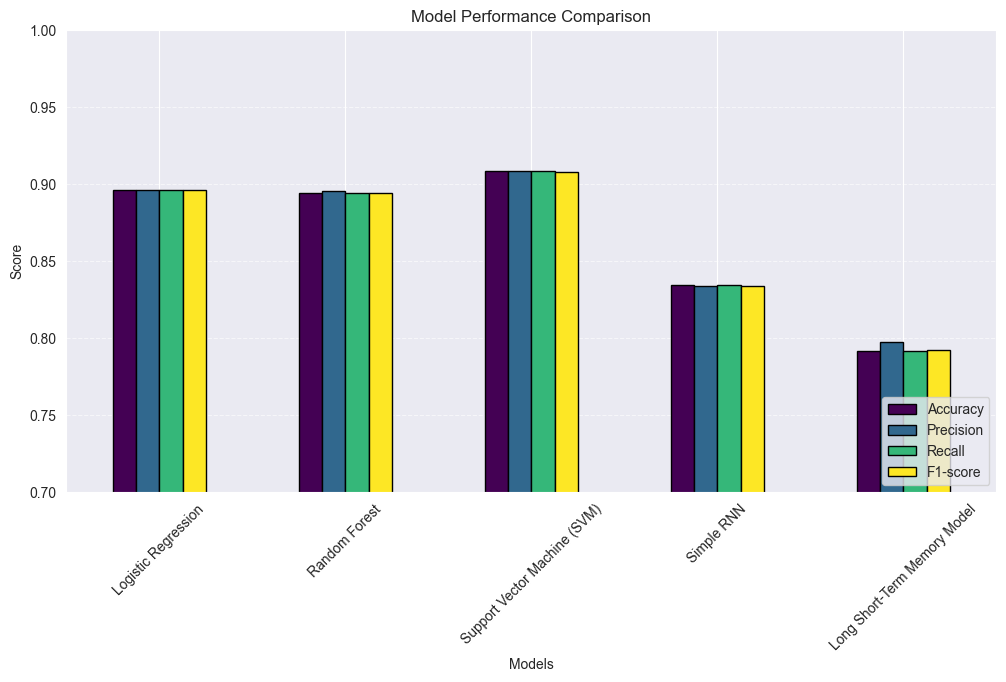

In [306]:
# Plot Performance Metrics

# Convert performance dictionary to DataFrame
performance_df = pd.DataFrame(performance_metrics).T  # Transpose for better visualization

plt.figure(figsize=(12, 6))
performance_df.plot(kind="bar", figsize=(12, 6), colormap="viridis", edgecolor="black")

plt.title("Model Performance Comparison")
plt.xlabel("Models")
plt.ylabel("Score")
plt.ylim(0.7, 1.0)  # Set y-axis limit for better visualization
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()

#### Logistic Regression, Random Forest, and SVM Performance

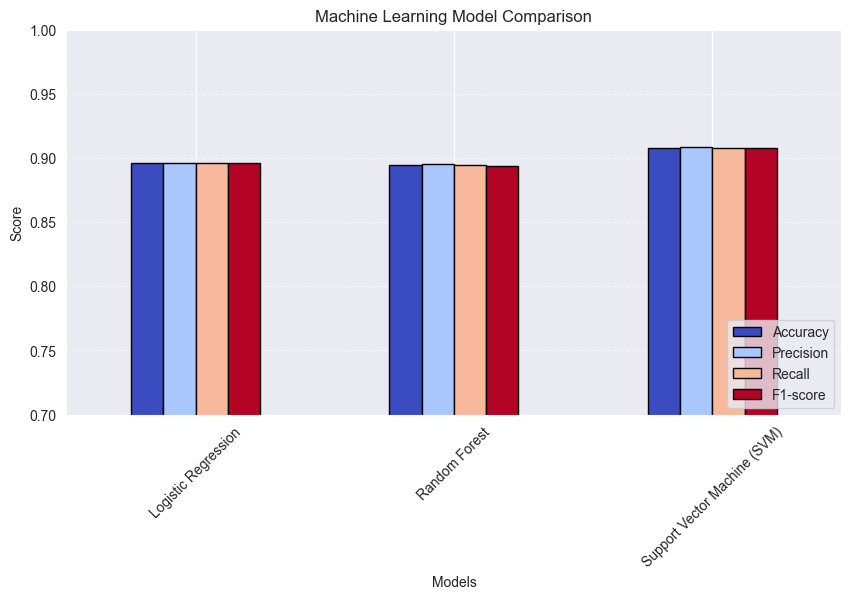

In [307]:
df_ml = performance_df.loc[['Logistic Regression', 'Random Forest', 'Support Vector Machine (SVM)']]
df_ml.plot(kind="bar", figsize=(10, 5), colormap="coolwarm", edgecolor="black")
plt.title("Machine Learning Model Comparison")
plt.xlabel("Models")
plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

#### Simple RNN and LSTM Performance

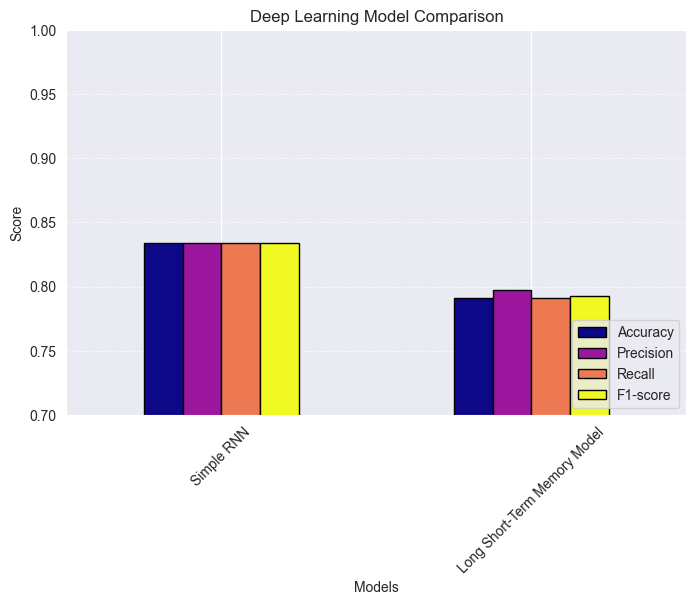

In [308]:
df_dl = performance_df.loc[['Simple RNN', 'Long Short-Term Memory Model']]
df_dl.plot(kind="bar", figsize=(8, 5), colormap="plasma", edgecolor="black")
plt.title("Deep Learning Model Comparison")
plt.xlabel("Models")
plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

### Padding & Truncation for Deep Learning Models

In [309]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define maximum sequence length based on dataset analysis
MAX_SEQUENCE_LENGTH = 5000  # Adjust based on your data distribution

# Convert Sparse TF-IDF Matrix to Dense Format
XTfidf_dense = XTfidf.toarray()  # Convert entire dataset to dense format

# First, Split the Dataset (BEFORE Reshaping)
X_train, X_test, y_train, y_test = train_test_split(XTfidf_dense, y, test_size=0.2, random_state=42)

# Apply padding and truncation to ensure uniform length
X_train_padded = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Now, Reshape for RNN & LSTM (Add a Time Step Dimension)
X_train_reshaped = X_train_padded.reshape(X_train_padded.shape[0], 1, X_train_padded.shape[1])
X_test_reshaped = X_test_padded.reshape(X_test_padded.shape[0], 1, X_test_padded.shape[1])

# Print Shape for Verification
print(f"Original XTfidf shape: {XTfidf.shape}")
print(f"Padded X_train shape: {X_train_padded.shape}")
print(f"Padded X_test shape: {X_test_padded.shape}")
print(f"Reshaped X_train shape: {X_train_reshaped.shape}")
print(f"Reshaped X_test shape: {X_test_reshaped.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


Original XTfidf shape: (5004, 5000)
Padded X_train shape: (4003, 5000)
Padded X_test shape: (1001, 5000)
Reshaped X_train shape: (4003, 1, 5000)
Reshaped X_test shape: (1001, 1, 5000)
y_train shape: (4003,)
y_test shape: (1001,)


In [310]:
# Train the model
rnn_model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.1607 - loss: 2.0335
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.1716 - loss: 1.8092
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.1556 - loss: 1.7926
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.1572 - loss: 1.7921
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.1797 - loss: 1.7917
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.1605 - loss: 1.7917
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.1723 - loss: 1.7910
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.1725 - loss: 1.7912
Epoch 9/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.1834 - loss: 1.7913
Epoch 10/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.1683 - loss: 1.7912
